In [1]:
cd ..

d:\min\research_projects\FedImpute


d:\min\research_projects\FedImpute\.venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import pandas as pd
import tabulate

# Load Data

In [3]:
%load_ext autoreload
%autoreload 2

from fedimpute.data_prep import load_data, display_data, column_check
from fedimpute.scenario import ScenarioBuilder
data, data_config = load_data("fed_heart_disease")
scenario_builder = ScenarioBuilder()
scenario_data = scenario_builder.create_real_scenario(
    data, data_config,
)
scenario_builder.summarize_scenario()

Scenario Summary
Total clients: 4
Global Test Data: (94, 21)
Missing Mechanism Category: MCAR
Clients Data Summary:
     Train     Test      Miss     MS Ratio    MS Feature    Seed
--  --------  -------  --------  ----------  ------------  ------
C1  (244,21)  (28,21)  (244,20)     0.00         0/20       6077
C2  (237,21)  (27,21)  (237,20)     0.04         4/20       577
C3  (99,21)   (11,21)  (99,20)      0.01         3/20       7231
C4  (162,21)  (18,21)  (162,20)     0.07         5/20       5504



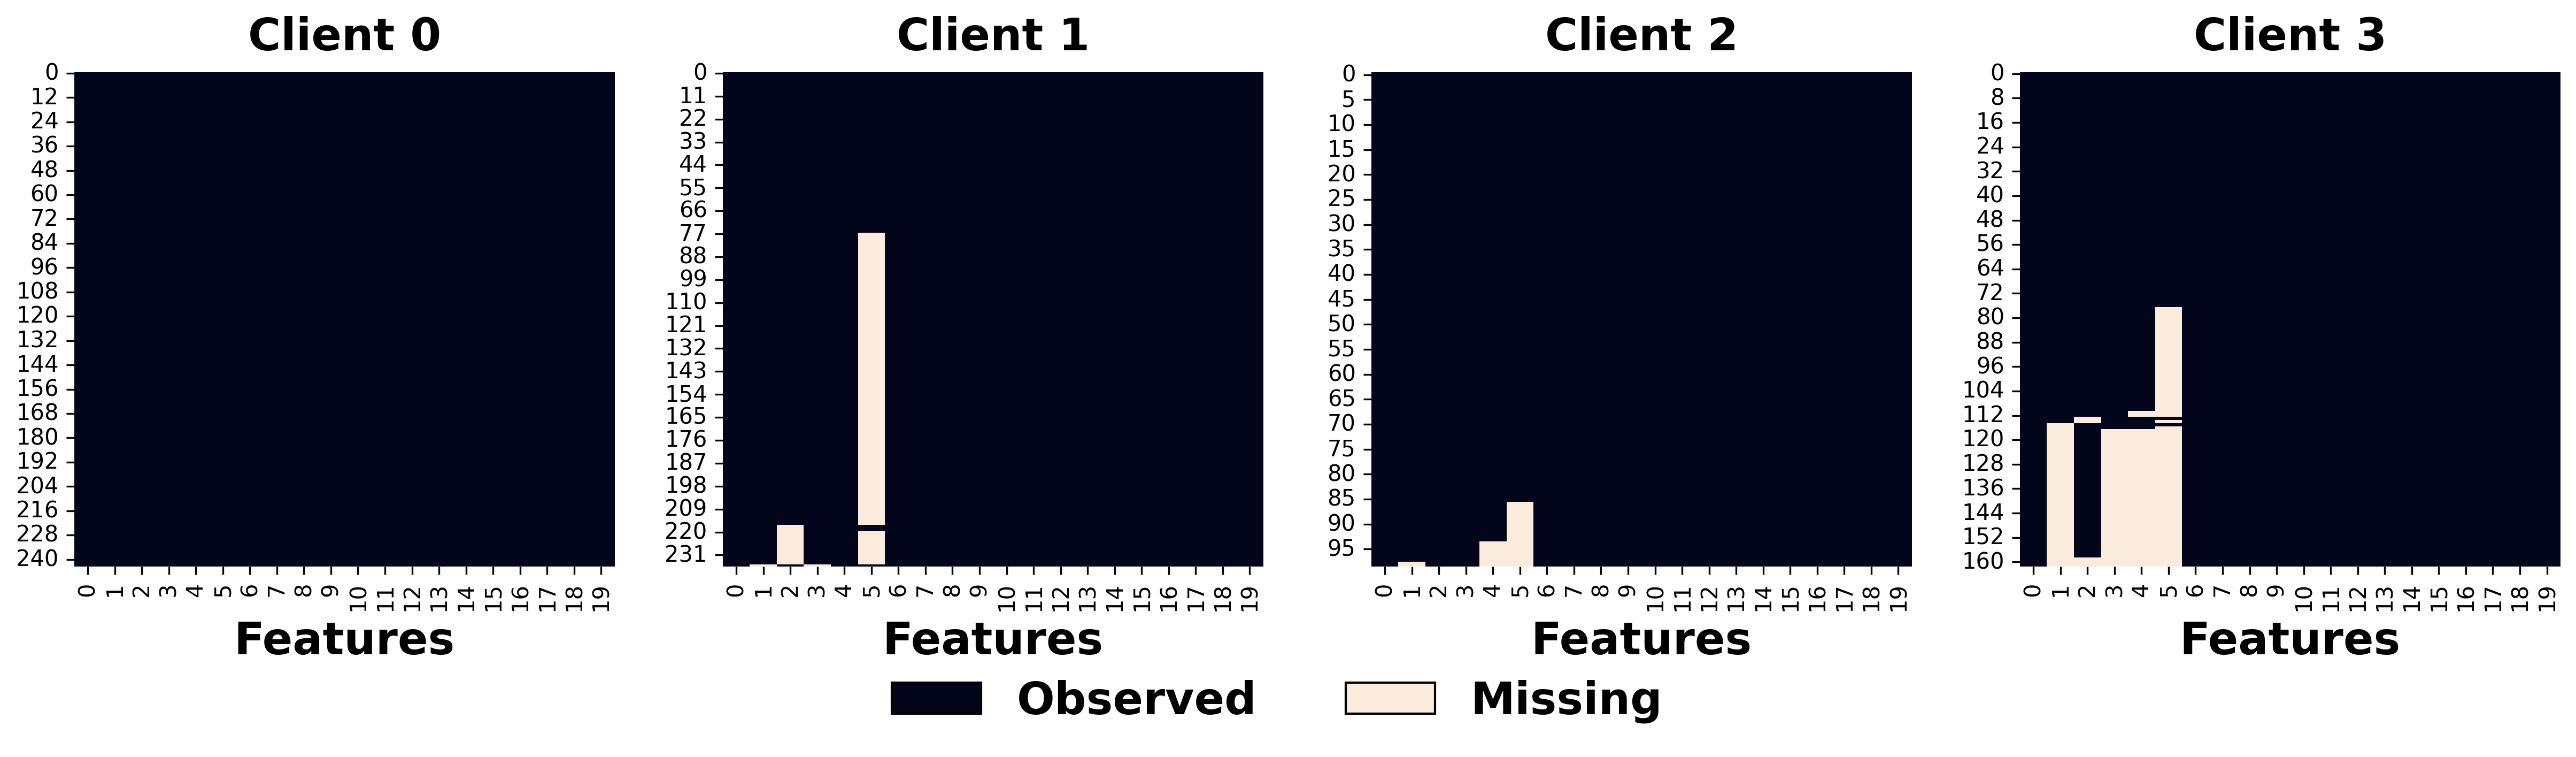

In [10]:
scenario_builder.visualize_missing_pattern(
    client_ids=[0, 1, 2, 3], data_type='train', fontsize=20, save_path='./plots/real_pattern_train.png'
)

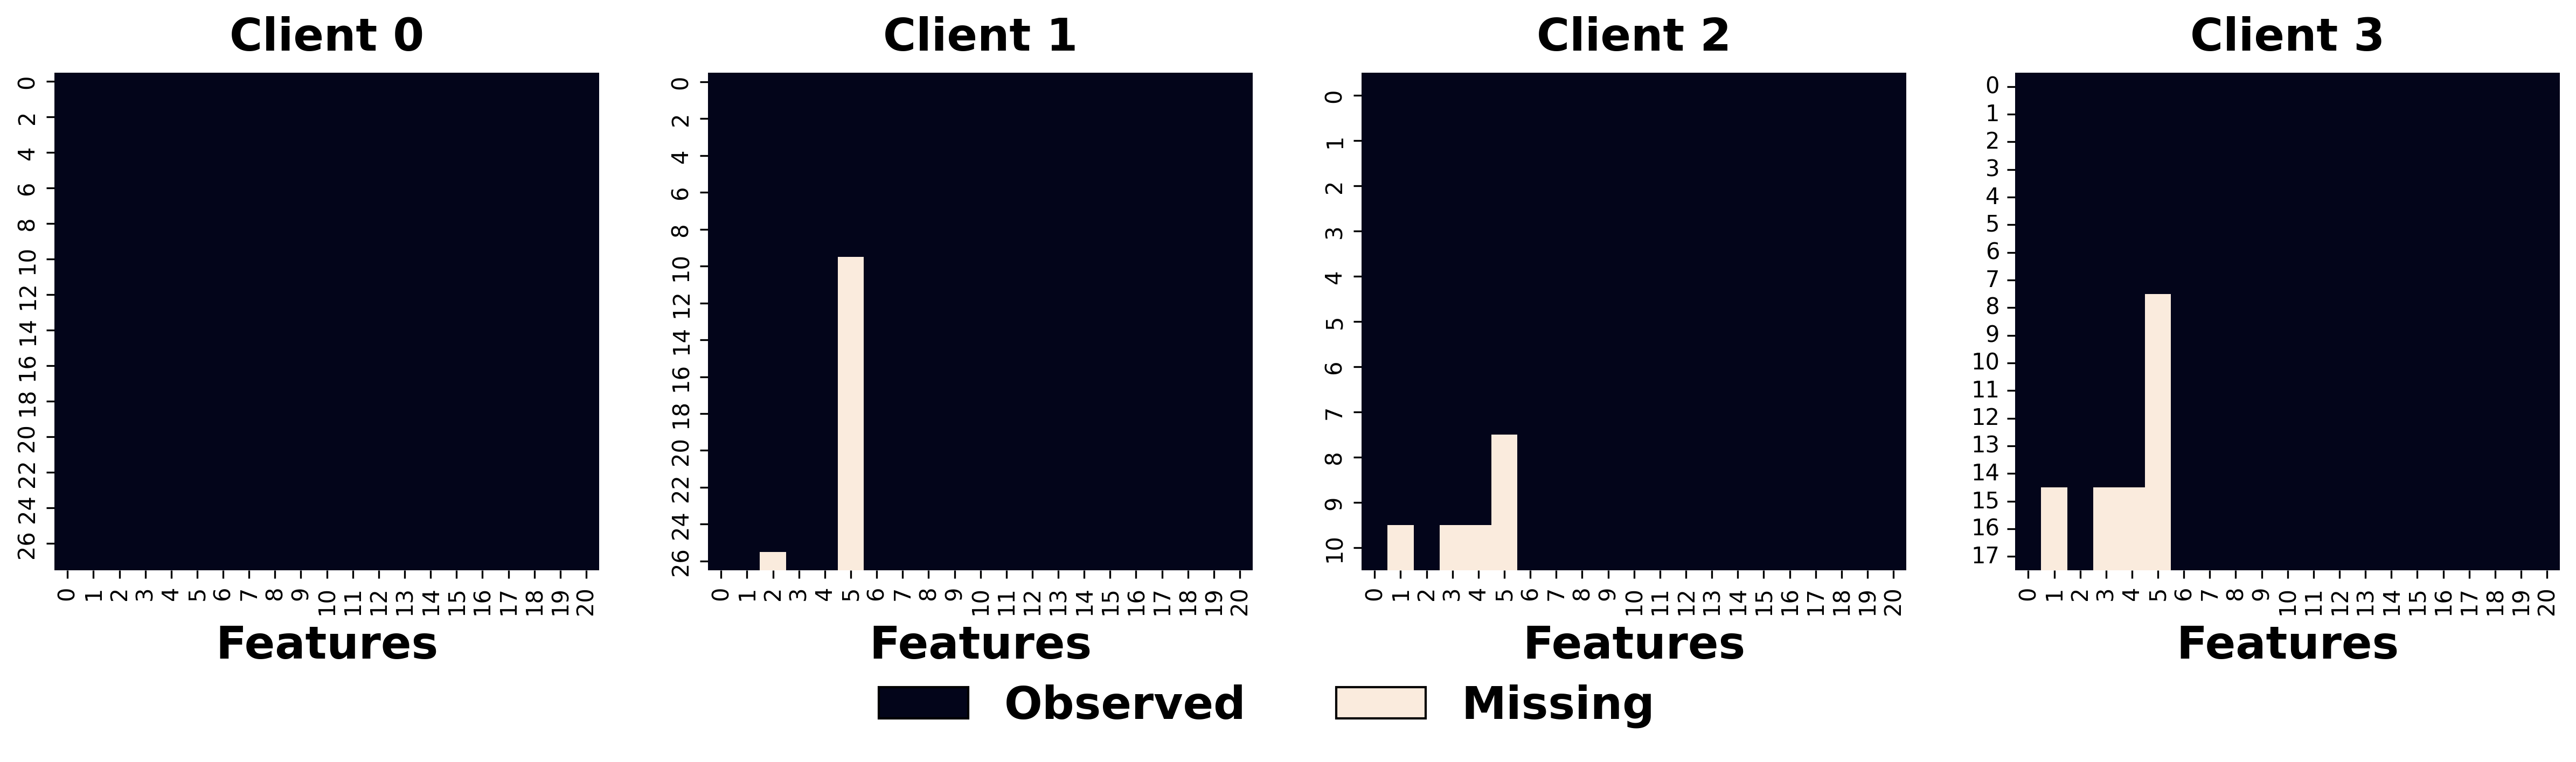

In [9]:
scenario_builder.visualize_missing_pattern(
    client_ids=[0, 1, 2, 3], data_type='test', fontsize=20, save_path='./plots/real_pattern_test.png'
)

# Running Federated Imputation

In [45]:
%load_ext autoreload
%autoreload 2
from fedimpute.execution_environment import FedImputeEnv

env = FedImputeEnv(debug_mode=False)
env.configuration(imputer = 'mice', fed_strategy='fedmice', workflow_params = {})
env.setup_from_scenario_builder(scenario_builder = scenario_builder, verbose=1)
env.show_env_info()
env.run_fed_imputation(verbose=1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Setting up clients...
Setting up server...
Setting up workflow...
Environment setup complete.
Environment Information:
Workflow: ICE (Imputation via Chain Equation)
Clients:
 - Client 0: imputer: mice, fed-strategy: fedmice
 - Client 1: imputer: mice, fed-strategy: fedmice
 - Client 2: imputer: mice, fed-strategy: fedmice
 - Client 3: imputer: mice, fed-strategy: fedmice
Server: fed-strategy: fedmice

Imputation Start ...


ICE Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Feature_idx:   0%|          | 0/20 [00:00<?, ?it/s]

Feature_idx:   0%|          | 0/20 [00:00<?, ?it/s]

Feature_idx:   0%|          | 0/20 [00:00<?, ?it/s]

Feature_idx:   0%|          | 0/20 [00:00<?, ?it/s]

Feature_idx:   0%|          | 0/20 [00:00<?, ?it/s]

Feature_idx:   0%|          | 0/20 [00:00<?, ?it/s]

Feature_idx:   0%|          | 0/20 [00:00<?, ?it/s]

Feature_idx:   0%|          | 0/20 [00:00<?, ?it/s]

Feature_idx:   0%|          | 0/20 [00:00<?, ?it/s]

Feature_idx:   0%|          | 0/20 [00:00<?, ?it/s]

Finished. Running time: 1.0724 seconds


# Evaluation

In [46]:
%load_ext autoreload
%autoreload 2
from fedimpute.evaluation import Evaluator

evaluator = Evaluator()

X_trains, y_trains = env.get_data(client_ids='all', data_type = 'train', include_y=True)
X_tests, y_tests = env.get_data(client_ids='all', data_type = 'test', include_y=True)
X_train_imps = env.get_data(client_ids='all', data_type = 'train_imp')
X_test_imps = env.get_data(client_ids='all', data_type = 'test_imp')
data_config = env.get_data(data_type = 'config')

ret = evaluator.evaluate_local_pred(
    X_train_imps = X_train_imps,
    y_trains = y_trains,
    X_tests = X_test_imps,
    y_tests = y_tests,
    data_config = data_config,
    model = 'nn',
    seed= 0
)
evaluator.show_local_pred_results()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Clients:   0%|          | 0/4 [00:00<?, ?it/s]

Early stopping at epoch 316
Early stopping at epoch 324
Early stopping at epoch 249
Early stopping at epoch 288
Downstream Prediction (Local)
             accuracy       f1         auc         prc
----------  ----------  ----------  ----------  ----------
 Client 1     0.607       0.645       0.708       0.742
 Client 2     0.852       0.778       0.953       0.933
 Client 3     0.909       0.952       0.100       0.848
 Client 4     0.722       0.828       0.631       0.799
----------  ----------  ----------  ----------  ----------
 Average      0.773       0.801       0.598       0.831
   Std        0.117       0.110       0.311       0.070


### Federated Prediction

In [47]:
X_train_imps = env.get_data(client_ids='all', data_type = 'train_imp')
X_test_imps = env.get_data(client_ids='all', data_type = 'test_imp')
X_global_test_imp = env.get_data(data_type = 'global_test_imp')

_ , y_trains = env.get_data(
    client_ids='all', data_type = 'train', include_y=True
)
_ , y_tests = env.get_data(
    client_ids='all', data_type = 'test', include_y=True
)
_, y_global_test = env.get_data(
    data_type = 'global_test', include_y = True
)
data_config = env.get_data(data_type = 'config')

ret = evaluator.evaluate_fed_pred(
    X_train_imps = X_train_imps,
    y_trains = y_trains,
    X_tests = X_test_imps,
    y_tests = y_tests,
    X_test_global = X_global_test_imp,
    y_test_global = y_global_test,
    data_config = data_config,
    train_params = {
        'global_epoch': 100,
        'local_epoch': 10,
        'fine_tune_epoch': 200,
    },
    seed= 0
)

evaluator.show_fed_pred_results()

Global Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0 - average loss: 0.6512317483623822
Epoch 10 - average loss: 0.5921915372212728
Early stopping at epoch 11
Epoch 20 - average loss: 0.544242156876458
Epoch 30 - average loss: 0.5479222436745962
Early stopping at epoch 30
Epoch 40 - average loss: 0.5100965698560079
Early stopping at epoch 49
Epoch 50 - average loss: 0.48613545298576355
Early stopping at epoch 51
Early stopping at epoch 72
Downstream Prediction (Fed)
 Personalized    accuracy       f1         auc         prc
--------------  ----------  ----------  ----------  ----------
   Client 1       0.679       0.710       0.815       0.838
   Client 2       0.852       0.778       0.976       0.962
   Client 3       0.909       0.952       0.700       0.970
   Client 4       0.833       0.897       0.523       0.716
  ----------    ----------  ----------  ----------  ----------
    Global        0.798       0.812       0.873       0.860
